# Module 2  -  Naive Bayes Classification

In [ ]:
import pandas as pd
import os,sys,inspect

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

PATH = '/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2'
sys.path.insert(0, PATH)

from sklearn.metrics import confusion_matrix, auc, roc_curve
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB
from fma_metadata import utils
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report


In [58]:
# utility function
def make_confusion_matrix( cfm, title):
    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                cfm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cfm.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    plt.title(title)
    
    sns.heatmap(cfm, annot=labels, fmt="", cmap='Blues')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted',fontsize=12)
    

def plot_roc_curve(y_test, prediction, name_model):
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, prediction)

    plt.grid()
    auc_score = round(auc(test_fpr, test_tpr),2)
    plt.plot(test_fpr, test_tpr, label=f"{name_model} - AUC ="+ str(auc_score))
    plt.plot([0,1],[0,1],'r--')
    plt.legend()
    plt.xlabel("True Positive Rate")
    plt.ylabel("False Positive Rate")
    plt.title(f" AUC(ROC curve) - {name_model}")
    plt.grid(color='black', linestyle='', linewidth=0.5)
    plt.show()

In [36]:
# read dataset 
data = utils.load('/Users/gaetanoantonicchio/Desktop/dataset_DM2/fma_metadata/features.csv')
data.head()

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20           -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.054125  0.012226   
3           1.366848  1.054094  0.108103  0.619185  ...  0.063831  0.014212   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.040730  0.012691   
10          1.770694  1.604566  0.521217  1.982386  ...  0.074358  0.017952   
20         -0.289294 -0.816410  0.043851 -0.804761  ...  0.095003  0.022492   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            06         01        01        01        01        01   
track_id                                                                  
2           0.012111   5.758890  0.459473  0.085629  0.071289  0.000000   
3           0.017740   2.824694  0.466309  0.084578  0.063965  0.000000   
5           0.014759   6.808415  0.375000  0.053114  0.041504  0.000000   
10          0.013921  21.434212  0.452148  0.077515  0.071777  0.000000   
20          0.021355  16.669037  0.469727  0.047225  0.040039  0.000977   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
2           2.089872  0.061448  
3           1.716724  0.069330  
5           2.193303  0.044861  
10          3.542325  0.040800  
20          3.189831  0.030993  

[5 rows x 518 columns]

In [37]:
# read labels: song_happiness
labels = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/src/Data (cleaned)/Labels/song_happiness_labels.csv')
label= labels.set_index('track_id')

#merge labels with data
data = data.merge(labels, on='track_id')

# remove duplicate rows
data.drop_duplicates(keep=False, inplace=True)
# remove Null values (if there are)
data.dropna()

# reset index to track_id
data = data.set_index('track_id')
data.rename({'valence': 'song_emotion'}, axis='columns', inplace=True)
# view data
data.head()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,"(chroma_cens, kurtosis, 01)","(chroma_cens, kurtosis, 02)","(chroma_cens, kurtosis, 03)","(chroma_cens, kurtosis, 04)","(chroma_cens, kurtosis, 05)","(chroma_cens, kurtosis, 06)","(chroma_cens, kurtosis, 07)","(chroma_cens, kurtosis, 08)","(chroma_cens, kurtosis, 09)","(chroma_cens, kurtosis, 10)",...,"(tonnetz, std, 05)","(tonnetz, std, 06)","(zcr, kurtosis, 01)","(zcr, max, 01)","(zcr, mean, 01)","(zcr, median, 01)","(zcr, min, 01)","(zcr, skew, 01)","(zcr, std, 01)",song_emotion
track_id,,,,,,,,,,,,,,,,,,,,,
2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,...,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.0,2.089872,0.061448,happy
3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,0.619185,...,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.0,1.716724,0.069330,sad
5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,...,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.0,2.193303,0.044861,happy
10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,1.982386,...,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.0,3.542325,0.040800,happy
134,0.918445,0.674147,0.577818,1.281117,0.933746,0.078177,1.199204,-0.175223,0.925482,1.438509,...,0.016322,0.015819,4.731087,0.419434,0.064370,0.050781,0.0,1.806106,0.054623,happy


In [38]:
# check number of records per class
data.song_emotion.value_counts()

sad      7724
happy    5405
Name: song_emotion, dtype: int64

In [39]:
# encoding labels
le = LabelEncoder()
data['song_emotion'] = le.fit_transform(data['song_emotion'])
data.song_emotion.value_counts()

1    7724
0    5405
Name: song_emotion, dtype: int64

In [40]:
# remove labels from dataset 
labels = data[['song_emotion']]
data.drop('song_emotion', axis=1, inplace=True)


In [41]:
# split data in traning and test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30, random_state=42, stratify=labels,
                                                   shuffle=True) 

In [94]:
#help(GaussianNB)

In [43]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GaussianNB()

In [44]:
y_pred = classifier.predict(X_test)

In [45]:
print(classification_report(y_test,y_pred ))

              precision    recall  f1-score   support

           0       0.47      0.88      0.61      1622
           1       0.78      0.30      0.43      2317

    accuracy                           0.54      3939
   macro avg       0.62      0.59      0.52      3939
weighted avg       0.65      0.54      0.51      3939



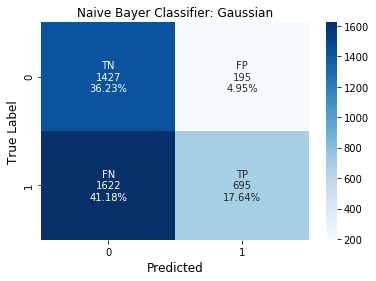

In [70]:
cf_matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix, 'Naive Bayer Classifier: Gaussian')

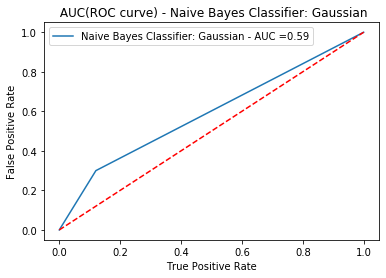

In [71]:
plot_roc_curve(y_test, y_pred, 'Naive Bayes Classifier: Gaussian')

In [62]:
bernoulliNB = BernoulliNB()
bernoulliNB.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


BernoulliNB()

In [63]:
y_pred_ber = bernoulliNB.predict(X_test)

In [64]:
print(classification_report(y_test,y_pred_ber ))

              precision    recall  f1-score   support

           0       0.53      0.62      0.57      1622
           1       0.70      0.62      0.66      2317

    accuracy                           0.62      3939
   macro avg       0.62      0.62      0.62      3939
weighted avg       0.63      0.62      0.62      3939



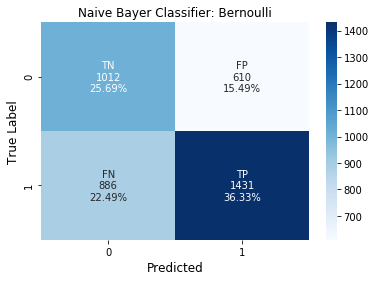

In [73]:
cf_matrix_ber = confusion_matrix(y_test, y_pred_ber)
make_confusion_matrix(cf_matrix_ber, 'Naive Bayer Classifier: Bernoulli')

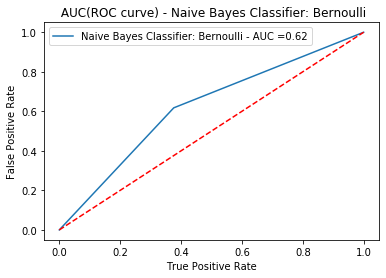

In [76]:
plot_roc_curve(y_test, y_pred_ber, 'Naive Bayes Classifier: Bernoulli')

In [93]:
bernoulliNB.feature_log_prob_

array([[-8.52950088e-01, -9.49873471e-01, -8.43693619e-01, ...,
        -6.90772196e-01, -9.02341579e-03, -2.64235700e-04],
       [-8.45204779e-01, -9.12415831e-01, -8.27286211e-01, ...,
        -7.26417799e-01, -2.45169948e-02, -1.84894149e-04]])

Bernoulli Naive Bayes has higher performance compared to Gaussian Naive Bayes.<br>
Both classifier are able to predict class 0 (in particular GaussianNB has a recall for the class of 0.8).

In [95]:
from sklearn.inspection import permutation_importance

In [96]:
result = permutation_importance(bernoulliNB, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

In [123]:
result.importances[sorted_idx][:10].shape

(10, 10)

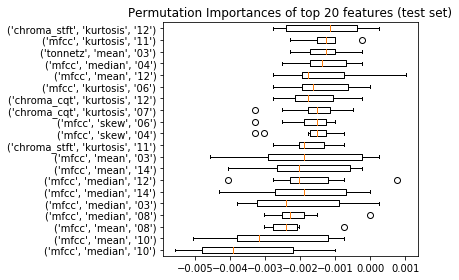

In [128]:
sorted_idx = result.importances_mean.argsort()
#plt.figure(figsize=(10,30))
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx][:20].T,
           vert=False, labels=X_test.columns[sorted_idx][:20])
ax.set_title("Permutation Importances of top 20 features (test set)")
fig.tight_layout()
plt.show()

Mfcc and chroma are the most important features for predicting song emotions with a Bernoulli Naive Bayes